Step 1: Initialize Spark Session and Setting up

In [25]:
# Install PySpark and Java
!apt-get update -y
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install -q findspark

!tar xf spark-3.5.3-bin-hadoop3.tgz

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

# Complete Code to Train, Evaluate, and Display Predictions for House Price Models with Diagrams and Comparison Table

# Initialize Spark Session
from pyspark.sql import SparkSession
import findspark
findspark.init()

spark = SparkSession.builder \
    .appName("OptimizedHousePricePrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Apache Spark is ready!")


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Apache Spark is ready!


#Load and Preprocess Data

In [26]:
# Load and Preprocess Data
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col, when, isnan

# Load dataset
data = spark.read.csv("Bengaluru_House_Data.csv", header=True, inferSchema=True)

# Cast necessary columns to double
data = data.withColumn("total_sqft", data["total_sqft"].cast("double"))
data = data.withColumn("bath", data["bath"].cast("double"))
data = data.withColumn("balcony", data["balcony"].cast("double"))

# Fill missing values
data = data.fillna({"bath": 0, "balcony": 0, "price": 0, "total_sqft": 0})

# Feature Engineering: Add derived features
data = data.withColumn("price_per_sqft", when(col("total_sqft") > 0, col("price") / col("total_sqft")).otherwise(0))

# Encode categorical features
indexer = StringIndexer(inputCol="location", outputCol="location_indexed", handleInvalid="skip")
data = indexer.fit(data).transform(data)

# Filter out NaN or infinite values
data = data.filter(~(isnan(col("total_sqft")) | isnan(col("bath")) | isnan(col("balcony")) | isnan(col("price_per_sqft")) | isnan(col("location_indexed"))))

# Assemble features
assembler = VectorAssembler(
    inputCols=["total_sqft", "bath", "balcony", "price_per_sqft", "location_indexed"],
    outputCol="raw_features"
)
data = assembler.transform(data)

# Standardize features
scaler = StandardScaler(inputCol="raw_features", outputCol="features")
data = scaler.fit(data).transform(data)

# Split data into training and test sets
train_data, test_data = data.randomSplit([0.85, 0.15], seed=147)

# Data Exploration and Summary Statistics

In [27]:
# Display dataset schema and summary statistics
print("Schema:")
data.printSchema()

print("Summary statistics:")
data.describe().show()

# Check for null values in each column
data.select([col(c).isNull().alias(c) for c in data.columns]).show()

# Identify important features for model building
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=5, featuresCol="features", outputCol="selected_features", labelCol="price")
selected_data = selector.fit(data).transform(data)

print("Selected features:")
selected_data.select("selected_features").show(5)

Schema:
root
 |-- area_type: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- location: string (nullable = true)
 |-- size: string (nullable = true)
 |-- society: string (nullable = true)
 |-- total_sqft: double (nullable = false)
 |-- bath: double (nullable = false)
 |-- balcony: double (nullable = false)
 |-- price: double (nullable = false)
 |-- price_per_sqft: double (nullable = true)
 |-- location_indexed: double (nullable = false)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

Summary statistics:
+-------+--------------------+-------------+----------+---------+-------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|           area_type| availability|  location|     size|society|        total_sqft|              bath|           balcony|             price|     price_per_sqft|  location_indexed|
+-------+--------------------+-------------+-------

# Convert selected features into final feature vector

In [28]:
# Convert selected features into final feature vector
final_assembler = VectorAssembler(
    inputCols=["price_per_sqft", "location_indexed"],
    outputCol="final_features"
)
final_data = final_assembler.transform(selected_data)

print("Final features:")
final_data.select("final_features").show(5)

# Verify train-test split
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Final features:
+--------------------+
|      final_features|
+--------------------+
|[0.03699810606060...|
|[0.04615384615384...|
|[0.04305555555555...|
|[0.06245890861275...|
|       [0.0425,36.0]|
+--------------------+
only showing top 5 rows

Training Data Count: 11382
Test Data Count: 1937


# Define Evaluation Function


Linear Regression Performance:
  RMSE: 80.13
  MAE: 41.83
  R-squared: 0.51


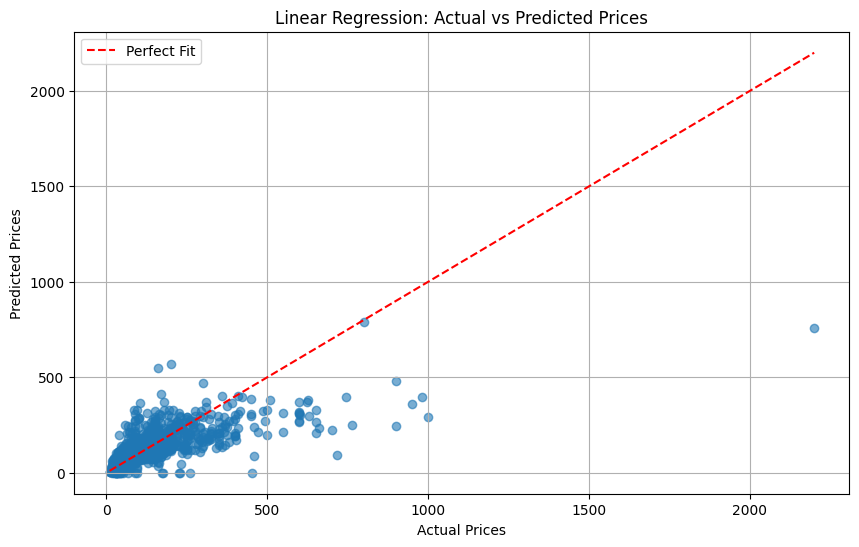

Decision Tree Performance:
  RMSE: 48.48
  MAE: 21.05
  R-squared: 0.82


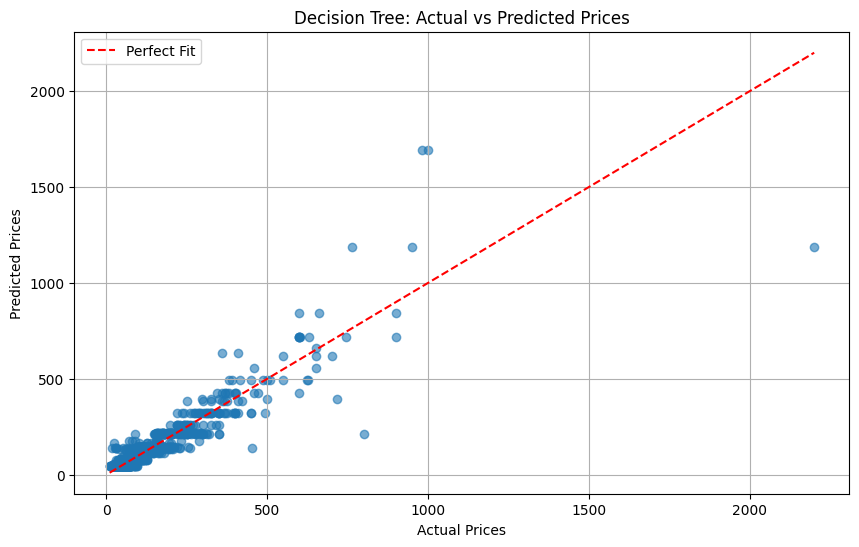

Random Forest Performance:
  RMSE: 47.92
  MAE: 20.71
  R-squared: 0.83


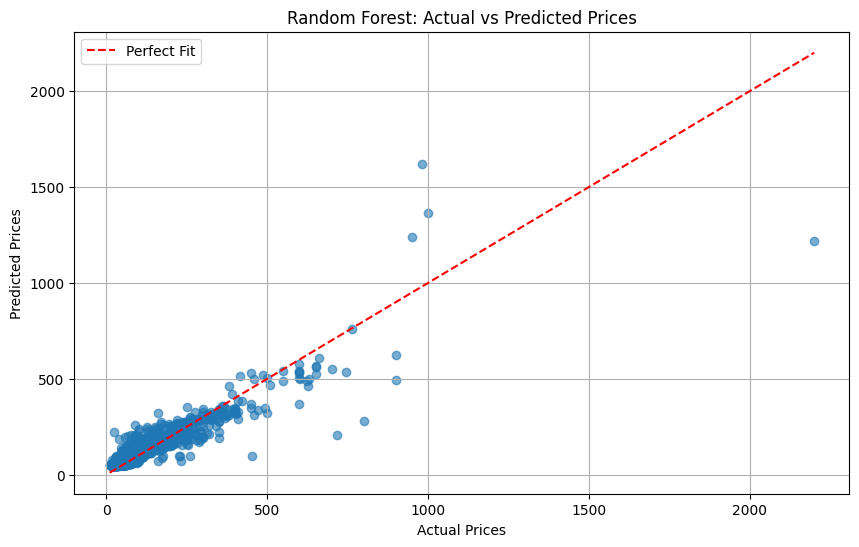

Gradient-Boosted Trees Performance:
  RMSE: 44.57
  MAE: 13.18
  R-squared: 0.85


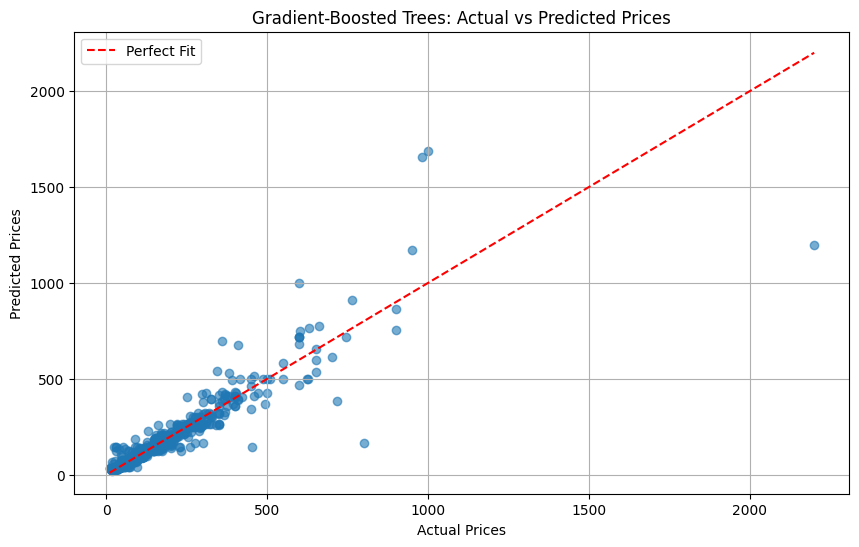

In [29]:
# Define Evaluation Function
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluation function
def evaluate_model(predictions, model_name):
    evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R-squared: {r2:.2f}")
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "R2": r2}

# Initialize a list to store model performance
model_performance = []

# Train and evaluate each model
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define models and parameter grids
models = {
    "Linear Regression": (LinearRegression(featuresCol="features", labelCol="price", predictionCol="prediction"),
                           ParamGridBuilder().addGrid(LinearRegression().regParam, [0.01, 0.1]).addGrid(LinearRegression().elasticNetParam, [0.0, 0.5]).build()),
    "Decision Tree": (DecisionTreeRegressor(featuresCol="features", labelCol="price", predictionCol="prediction"),
                       ParamGridBuilder().addGrid(DecisionTreeRegressor().maxDepth, [5, 10, 20]).build()),
    "Random Forest": (RandomForestRegressor(featuresCol="features", labelCol="price", predictionCol="prediction"),
                       ParamGridBuilder().addGrid(RandomForestRegressor().numTrees, [50, 100]).addGrid(RandomForestRegressor().maxDepth, [10, 20]).build()),
    "Gradient-Boosted Trees": (GBTRegressor(featuresCol="features", labelCol="price", predictionCol="prediction"),
                                ParamGridBuilder().addGrid(GBTRegressor().maxIter, [20, 50]).addGrid(GBTRegressor().stepSize, [0.1, 0.2]).build())
}

# Train, evaluate, and compare models
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

predictions_dfs = []  # To store predictions from each model

for model_name, (model, param_grid) in models.items():
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse"), numFolds=5)
    cv_model = crossval.fit(train_data)
    predictions = cv_model.transform(test_data)
    predictions = predictions.withColumn("prediction", when(col("prediction") < 0, 0).otherwise(col("prediction")))
    performance = evaluate_model(predictions, model_name)
    model_performance.append(performance)

    # Collect predictions for comparison table
    predictions_df = predictions.select("price", "prediction").toPandas()
    predictions_df = predictions_df.rename(columns={"prediction": model_name})
    predictions_dfs.append(predictions_df)

    # Plot Actual vs Predicted
    actual = predictions.select("price").rdd.flatMap(lambda x: x).collect()
    predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.6)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label="Perfect Fit")
    plt.title(f"{model_name}: Actual vs Predicted Prices")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:

predictions_dfs = []  # To store predictions from each model

for model_name, (model, param_grid) in models.items():
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse"), numFolds=5)
    cv_model = crossval.fit(train_data)
    predictions = cv_model.transform(test_data)
    predictions = predictions.withColumn("prediction", when(col("prediction") < 0, 0).otherwise(col("prediction")))
    performance = evaluate_model(predictions, model_name)
    model_performance.append(performance)

    # Collect predictions for comparison table
    predictions_df = predictions.select("price", "prediction").toPandas()
    predictions_df = predictions_df.rename(columns={"prediction": model_name})
    predictions_dfs.append(predictions_df)

    # Plot Actual vs Predicted
    actual = predictions.select("price").rdd.flatMap(lambda x: x).collect()
    predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.6)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label="Perfect Fit")
    plt.title(f"{model_name}: Actual vs Predicted Prices")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

,Model,RMSE,MAE,R2
0,Linear Regression,80.125879,41.831530,0.512680
1,Decision Tree,48.478517,21.048115,0.821611
2,Random Forest,47.920848,20.712139,0.825692
3,Gradient-Boosted Trees,44.565927,13.183525,0.849244



Model Comparison: RMSE



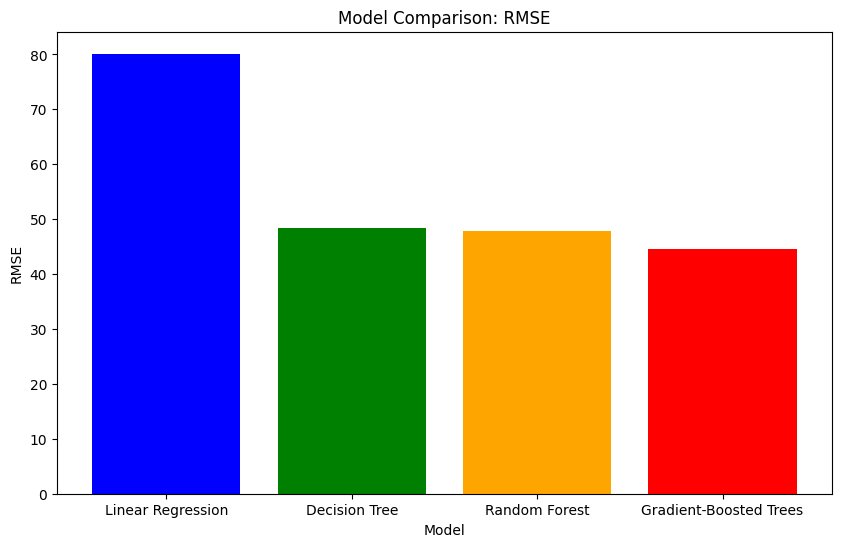


Model Comparison: MAE



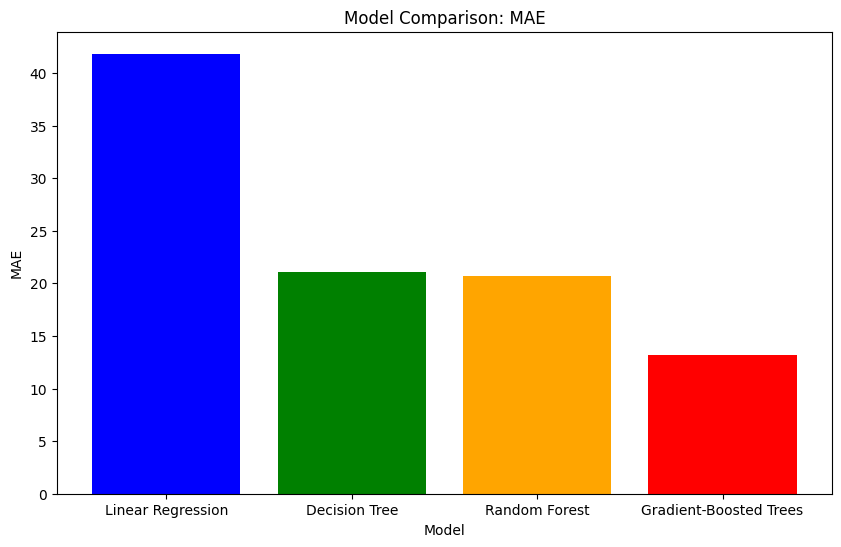


Model Comparison: R²



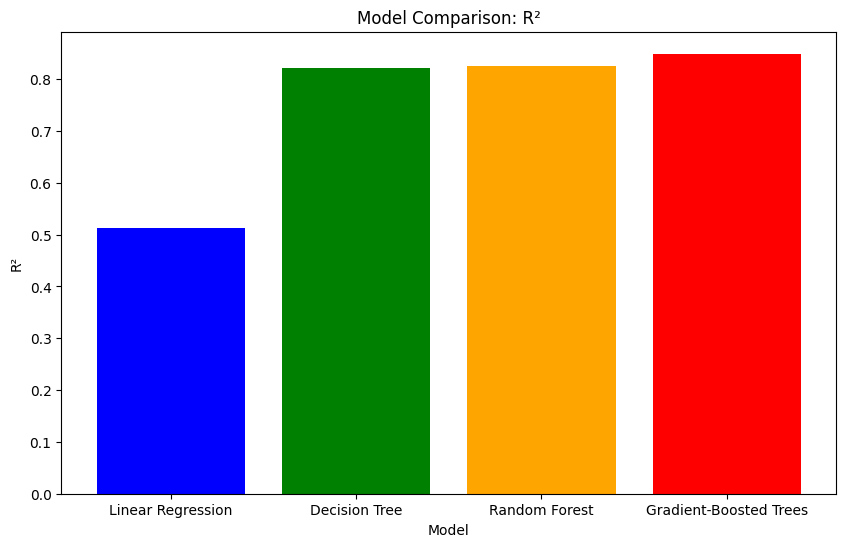

In [36]:
# Model comparison table
performance_df = pd.DataFrame(model_performance)
import IPython.display as display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(performance_df)

# # Plot model comparison as a bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(performance_df['Model'], performance_df['RMSE'], color=['blue', 'green', 'orange', 'red'])
# plt.title("Model Comparison: RMSE")
# plt.xlabel("Model")
# plt.ylabel("RMSE")
# plt.xticks(rotation=0)
# plt.show()

# Plot RMSE Comparison
print("\nModel Comparison: RMSE\n")
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['RMSE'], color=['blue', 'green', 'orange', 'red'])
plt.title("Model Comparison: RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.show()

# Plot MAE Comparison
print("\nModel Comparison: MAE\n")
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['MAE'], color=['blue', 'green', 'orange', 'red'])
plt.title("Model Comparison: MAE")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.xticks(rotation=0)
plt.show()

# Plot R² Comparison
print("\nModel Comparison: R²\n")
plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['R2'], color=['blue', 'green', 'orange', 'red'])
plt.title("Model Comparison: R²")
plt.xlabel("Model")
plt.ylabel("R²")
plt.xticks(rotation=0)
plt.show()


# Display the prediction table for all models


In [31]:
# Display the prediction table for all models
test_prices_df = test_data.select("price").toPandas().rename(columns={"price": "Actual Price"})
predictions_combined_df = pd.concat([test_prices_df] + [df.iloc[:, 1] for df in predictions_dfs], axis=1)
predictions_combined_df.columns = ["Actual Price"] + [df.columns[1] for df in predictions_dfs]
predictions_combined_df = predictions_combined_df.head(40)
import IPython.display as display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(predictions_combined_df)

,Actual Price,Linear Regression,Decision Tree,Random Forest,Gradient-Boosted Trees
0,43.71,108.040986,76.186243,66.468750,48.410384
1,65.00,60.563727,45.929510,59.250313,54.745527
2,177.00,170.174357,216.877743,173.867852,191.603542
3,57.00,67.752674,56.655718,54.598363,59.392860
4,143.00,93.213631,144.262582,131.417143,141.296239
5,60.00,73.154120,45.929510,52.308995,51.764144
6,224.00,225.736098,216.877743,207.769762,247.072007
7,92.00,122.891517,76.186243,93.719719,91.264814
8,29.45,67.958648,45.929510,49.019173,33.182067
9,170.00,155.118536,216.877743,170.466106,191.603542


# Select the best model based on RMSE, MAE, and R²


In [32]:
# Select the best model based on RMSE, MAE, and R²
best_model = performance_df.loc[performance_df['RMSE'].idxmin()]
print("\nBest Model Based on RMSE, MAE, and R²:")
print(best_model)

# Display the prediction table for the best model
best_model_name = best_model['Model']
best_predictions_df = next(df for df in predictions_dfs if best_model_name in df.columns)
# Drop unnecessary columns and ensure column alignment
final_comparison_df = pd.concat([test_data.drop("features", "raw_features").toPandas(), best_predictions_df[best_model_name]], axis=1)

# Keep all original columns except 'features' and 'raw_features' and add the best model's prediction
final_comparison_df.columns = list(test_data.drop("features", "raw_features").columns) + [best_model_name]

# Display the first 40 rows
final_comparison_df = final_comparison_df.head(40)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(final_comparison_df)

# Stop the Spark Session
spark.stop()



Best Model Based on RMSE, MAE, and R²:
Model    Gradient-Boosted Trees
RMSE                  44.565927
MAE                   13.183525
R2                     0.849244
Name: 3, dtype: object


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,price_per_sqft,location_indexed,Gradient-Boosted Trees
0,Built-up Area,14-Nov,Whitefield,3 BHK,None,1410.0,3.0,2.0,43.71,0.031000,0.0,48.410384
1,Built-up Area,16-Oct,Electronic City Phase II,3 BHK,Brods W,1252.0,2.0,3.0,65.00,0.051917,14.0,54.745527
2,Built-up Area,17-Dec,Hormavu,3 Bedroom,None,2400.0,3.0,1.0,177.00,0.073750,27.0,191.603542
3,Built-up Area,17-Jul,Electronic City,2 BHK,GMown E,1070.0,2.0,1.0,57.00,0.053271,2.0,59.392860
4,Built-up Area,18-Apr,Basavangudi,3 BHK,None,1500.0,2.0,1.0,143.00,0.095333,94.0,141.296239
5,Built-up Area,18-Apr,Varthur,2 BHK,Uptusol,1155.0,2.0,1.0,60.00,0.051948,35.0,51.764144
6,Built-up Area,18-Apr,Whitefield,4 BHK,None,3200.0,4.0,3.0,224.00,0.070000,0.0,247.072007
7,Built-up Area,18-Apr,Yelahanka,3 BHK,Hotat H,1847.0,3.0,3.0,92.00,0.049811,5.0,91.264814
8,Built-up Area,18-Aug,Bommasandra Industrial Area,2 BHK,None,1020.0,2.0,1.0,29.45,0.028873,112.0,33.182067
9,Built-up Area,18-Aug,Talaghattapura,3 BHK,Sodgere,2254.0,3.0,2.0,170.00,0.075421,76.0,191.603542
